# Qiskit 0.45.0 Release Highlights

Release will be published later today. The development build of the documentation includes **unedited** raw release notes you can refer to: https://qiskit.org/documentation/dev/release_notes.html#rc1

This is the last feature release before 1.0, accordingly this release includes many removals of previously deprecated functionality and new deprecations to prepare for the API changes we're planning to make in 1.0. It's also recommend if your project depends on  Qiskit that you proactively cap you supported version `< 1`.

In [1]:
import qiskit
qiskit.__version__

'0.45.0rc1'

# Singleton Gates

Starting in 0.45.0 unparameterized gates in the standard library are now singletons. This means by default there is only a single instance in memory of these gates and any subsequent usage is just a reference to that first one which results in faster creation time and also significantly reduced memory usage.

The full list of gate classes that are now singletons are:

`DCXGate`, `ECRGate`, `HGate`, `IGate`, `iSwapGate`, `SGate`, `SdgGate`, `SwapGate`, `SXGate`, `SXdgGate`, `TGate`, `TdgGate`, `XGate`, `RCCXGate`, `RC3XGate`, `YGate`, `ZGate`, `CHGate`, `CSGate`, `CSdgGate`, `CSwapGate`, `CSXGate`, `CXGate`, `CCXGate`, `C3SXGate`, `C3XGate`, `C4XGate`, `CYGate`, `CZGate`

In [2]:
from qiskit.circuit.library import XGate, CZGate, RZGate
from qiskit.circuit import QuantumCircuit

XGate() is XGate() is XGate() is XGate() is XGate() is XGate() is XGate() is XGate() is XGate()

True

In [3]:
CZGate() is CZGate() is CZGate() is CZGate() is CZGate() is CZGate() is CZGate() is CZGate() is CZGate() is CZGate() is CZGate() is CZGate() is CZGate()

True

In [4]:
gate = XGate()
print(f"name: {gate.name}")
print(f"params: {gate.params}")
print(f"matrix:\n{gate.to_matrix()}")
print(f"definition:\n{gate.definition}")

name: x
params: []
matrix:
[[0.+0.j 1.+0.j]
 [1.+0.j 0.+0.j]]
definition:
   ┌───────────┐
q: ┤ U3(π,0,π) ├
   └───────────┘


In [5]:
gate = XGate()
print(f"name: {gate.name}")
print(f"params: {gate.params}")
print(f"matrix:\n{gate.to_matrix()}")
print(f"definition:\n{gate.definition}")

name: x
params: []
matrix:
[[0.+0.j 1.+0.j]
 [1.+0.j 0.+0.j]]
definition:
   ┌───────────┐
q: ┤ U3(π,0,π) ├
   └───────────┘


In [6]:
import math
RZGate(math.pi) is RZGate(math.pi / 2)

False

In [7]:
RZGate(math.pi) is RZGate(math.pi)

False

## User impact of singletons

In [8]:
gate = XGate()
try:
    gate.label = "My bespoke x gate that gives me perfect results"
except TypeError as e:
    print(e)

This 'XGate' object is immutable. You can get a mutable version by calling 'to_mutable()'.


In [18]:
gate = XGate().to_mutable()
gate.label = "My bespoke x gate that gives me perfect results"
labelled_gate = XGate(label="My bespoke x gate that gives me perfect results")
print(labelled_gate.mutable)
qc = QuantumCircuit(1)
qc.append(gate, [0])
qc.append(labelled_gate, [0])
print(qc)

True
   ┌─────────────────────────────────────────────────┐»
q: ┤ My bespoke x gate that gives me perfect results ├»
   └─────────────────────────────────────────────────┘»
«   ┌─────────────────────────────────────────────────┐
«q: ┤ My bespoke x gate that gives me perfect results ├
«   └─────────────────────────────────────────────────┘


# Passmanager Generalization

In 0.45.0 we introduced a generic pass manager interface. This is a generalization of the pass manager that was used to build the transpiler.

This generic framework enables you to create a new pass manager that is using other intermediate representations (including multiple) and will be the framework to enable a pulse compiler and potential future improvements to the transpiler. It also cleaned up a lot of technical debt in the code and should improve the general usability and performance of working with pass managers.

In [10]:
from qiskit import passmanager

class ToyPassManager(passmanager.BasePassManager):
    """Synthetic example PassManager that takes input "programs" integers operates on them as strings and returns a final integer
    
    The transpiler's passmanager defines ``_passmanager_frontend`` as QuantumCircuit -> DAGCircuit and ``_passmanager_backend``
    as DAGCircuit -> QuantumCircuit
    """
    
    def _passmanager_frontend(self, input_program: int, **kwargs) -> str:
        """Convert input int to str "IR"""
        return str(input_program)

    def _passmanager_backend(self, passmanager_ir: str, in_program: int, **kwargs) -> int:
        """Convert str "IR" to output int"""
        return int(passmanager_ir)

In [11]:
class RemoveFive(passmanager.GenericPass):
    """Pass for ToyPassManager that removes the number 5 from a string "IR"""

    def run(self, passmanager_ir: str):
        return passmanager_ir.replace("5", "")

In [12]:
pm = ToyPassManager(RemoveFive())

pm.run([123456789, 12345, 555552])

[12346789, 1234, 2]

# Layout tools

0.45.0 added improved tools for reasoning about the layout permutations caused by the transpiler. In general the transpiler is unitary equivalent up to the permutations it causes by layout (i.e. qubit selection) and routing (i.e. swap insertion). To manage those permutations the `QuantumCircuit.layout` attribute on the output circuit returned the `TranspileLayout` class which contained metadata about those permutations. But, in previous releases the data contained in there was opaque and hard to use because it was what the transpiler uses internally and not clear.

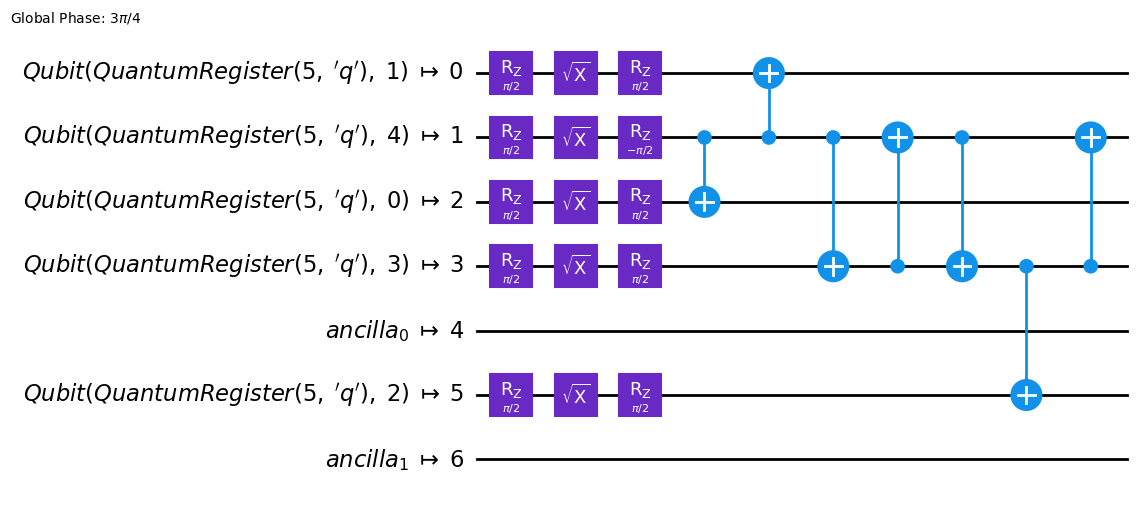

In [13]:
from qiskit.providers.fake_provider import FakeNairobiV2
from qiskit import transpile

qc = QuantumCircuit(5)
qc.x(4)
qc.h(range(5))
qc.cx(4, range(4))
tqc = transpile(qc, FakeNairobiV2(), optimization_level=3)
tqc.draw('mpl', fold=-1)

In [19]:
tqc.layout.initial_virtual_layout(filter_ancillas=True)

Layout({
2: Qubit(QuantumRegister(5, 'q'), 0),
0: Qubit(QuantumRegister(5, 'q'), 1),
5: Qubit(QuantumRegister(5, 'q'), 2),
3: Qubit(QuantumRegister(5, 'q'), 3),
1: Qubit(QuantumRegister(5, 'q'), 4)
})

In [15]:
tqc.layout.final_index_layout()

[2, 0, 5, 1, 3]

## Use this with the Estimator

In [16]:
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import BackendEstimator
from qiskit.compiler import transpile

psi = RealAmplitudes(num_qubits=2, reps=2)
H1 = SparsePauliOp.from_list([("II", 1), ("IZ", 2), ("XI", 3)])
backend = FakeNairobiV2()
estimator = BackendEstimator(backend=backend, skip_transpilation=True)

thetas = [0, 1, 1, 2, 3, 5]
transpiled_psi = transpile(psi, backend, optimization_level=3)
# New in 0.45.0 inflate and permute:
print(f"original operator:\n{H1}\n")
permuted_op = H1.apply_layout(transpiled_psi.layout)
print(f"final layout: {transpiled_psi.layout.final_index_layout()}\n")
print(f"operator with layout applied:\n{permuted_op}\n")
res = estimator.run(transpiled_psi, permuted_op, thetas, shots=int(1e5)).result()
print(res)

original operator:
SparsePauliOp(['II', 'IZ', 'XI'],
              coeffs=[1.+0.j, 2.+0.j, 3.+0.j])

final layout: [1, 2]

operator with layout applied:
SparsePauliOp(['IIIIIII', 'IIIIIZI', 'IIIIXII'],
              coeffs=[1.+0.j, 2.+0.j, 3.+0.j])

EstimatorResult(values=array([1.55638]), metadata=[{'variance': 9.007717975600002, 'shots': 100000}])


/home/computertreker/Presentations/qiskit-deep-dive/release/lib/python3.11/site-packages/qiskit/providers/fake_provider/fake_backend.py:355: RuntimeWarning: Aer not found using BasicAer and no noise
  warnings.warn("Aer not found using BasicAer and no noise", RuntimeWarning)


# Performance Improvements


![memory](rss_singleton.png "memory")
![memory](rss_zsx.png "memory")
![build](build_time.png "build")
![bind](bind_time.png "bind")
![level_0](transpile_time_level_0.png "level_0")
![level_1_ghz](runtime_version_compare.png "lvl1_ghz")